In [1]:
import pandas as pd
from vedo import Mesh, Plotter, Text2D,settings

In [2]:
df_features = pd.read_csv("mesh_features.csv")
X = df_features.drop(["mesh_name", "class"], axis=1)
X.head()

,area,volume,rectangularity,compactness,convexity,eccentricity,diameter,A3_bin_0,A3_bin_1,A3_bin_2,...,D4_bin_center_20,D4_bin_center_21,D4_bin_center_22,D4_bin_center_23,D4_bin_center_24,D4_bin_center_25,D4_bin_center_26,D4_bin_center_27,D4_bin_center_28,D4_bin_center_29
0,2.567595,0.338307,0.401367,1.307688,0.859908,1.143945,1.033568,0.000000,0.001750,0.006999,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
1,3.314142,0.359405,0.391703,2.491678,0.836037,1.798762,1.047357,0.002276,0.007587,0.008346,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
2,3.172938,0.263182,0.677445,4.077757,1.562505,4.874752,1.000015,0.009857,0.018817,0.020609,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
3,0.561321,0.027836,0.217335,2.018231,0.610430,12.169459,0.999651,0.017274,0.024952,0.044146,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
4,0.671115,0.035075,0.251780,2.172427,0.686432,8.510702,0.998808,0.017117,0.028829,0.036036,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667


In [3]:
non_hist_features = ['area', 'volume', 'rectangularity', 'compactness', 'convexity', 'eccentricity', 'diameter']
hist_features = X.columns.difference(non_hist_features)
hist_features = hist_features[~(hist_features.str.contains('center'))]
grouped_columns = hist_features.groupby(hist_features.str[:2])
grouped_index_cols = {k: sorted([X.columns.get_loc(c) for c in v]) for k,v in grouped_columns.items()}
X[non_hist_features] = (X[non_hist_features] - X[non_hist_features].mean()) / X[non_hist_features].std()


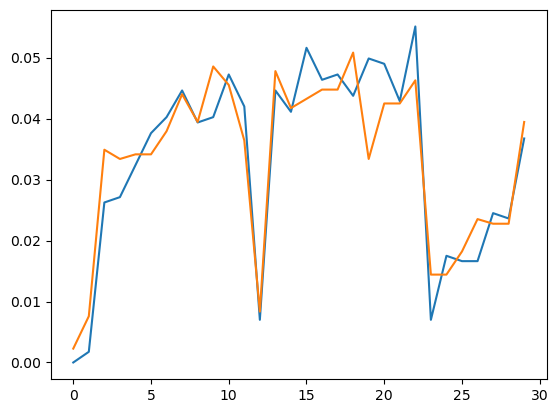

(0.0025932519689464573, 0.0025932519689464573)

In [4]:
from scipy.stats import wasserstein_distance as emd
from matplotlib import pyplot as plt
import numpy as np

a3 = grouped_columns['A3']

u, v = X[a3].iloc[:2].to_numpy()
u.shape
# u, v
plt.plot(u)
plt.plot(v)
plt.show()
emd(u, v), emd(v, u) # def combined_dist(x, v):



In [5]:
def hist_distances(u, v, plot=False):
    dist = np.zeros(len(grouped_columns))
    for i, cols in enumerate(grouped_index_cols.values()):
        dist[i] = emd(u[cols], v[cols])
        if plot: 
            plt.plot(u[cols])
            plt.plot(v[cols])
            plt.show()
            print(i, dist[i])
    return dist

hist_distances(X.iloc[364].to_numpy(), X.iloc[147].to_numpy())


array([0.00262545, 0.00717358, 0.00469944, 0.00460239, 0.00683589])

In [6]:
def dist_func(u, v, weights = 1.):
    dist = np.zeros(len(non_hist_features) + len(grouped_columns))
    dist[:len(non_hist_features)] = np.abs(u[:len(non_hist_features)] - v[:len(non_hist_features)])
    dist[len(non_hist_features):] = hist_distances(u, v)

    return (weights * dist)

dist_func(X.iloc[364].to_numpy(), X.iloc[147].to_numpy()).sum()  # Car vs Biplane

3.6857771361515757

In [7]:
dist_func(X.iloc[0].to_numpy(), X.iloc[1].to_numpy()).sum()  # Two objects of the same class


0.8669646773294267

In [8]:
grouped_columns.keys()

dict_keys(['A3', 'D1', 'D2', 'D3', 'D4'])

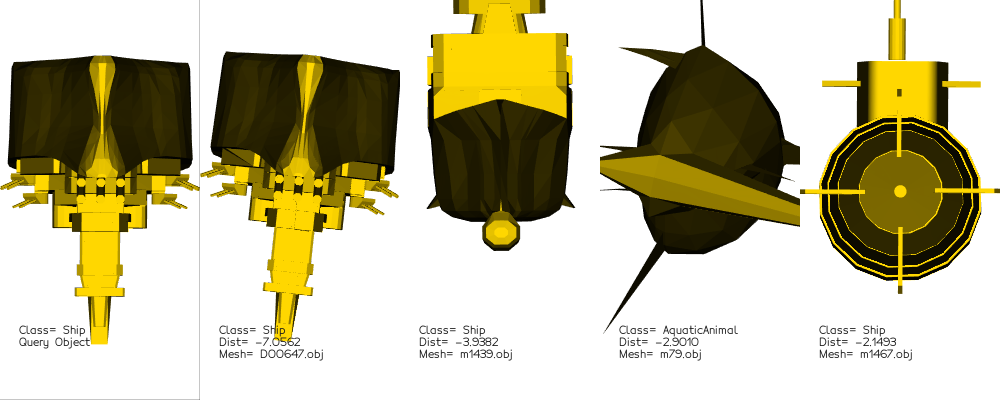

In [16]:
def dist_plot(query_idx, idx, dist, df_features):

    pltr = Plotter((1, len(idx)), size=[1000, 400])

    # Add the first mesh and its label
    mesh0 = Mesh(f"../normshapes/{df_features.loc[query_idx, 'class']}/{df_features.loc[query_idx, 'mesh_name']}")
    pltr.add(mesh0, at=0)
    pltr.parallel_projection(at=0)
    pltr.add(Text2D(f"Class= {df_features.loc[query_idx, 'class']}", pos=(0.1, 0.2), s=0.5), at=0)
    pltr.add(Text2D(f"Query Object", pos=(0.1, 0.17), s=0.5), at=0)

    # Add the rest of the meshes and their labels
    for j, i in enumerate(idx[1::], start=1):
        mesh = Mesh(f"../normshapes/{df_features.loc[i, 'class']}/{df_features.loc[i, 'mesh_name']}")
        pltr.add(mesh, at=j)
        pltr.parallel_projection(at=j)

        pltr.add(Text2D(f"Class= {df_features.loc[i, 'class']}", pos=(0.1, 0.2), s=0.5), at=j)
        pltr.add(Text2D(f"Dist= {dist[j-1]:.4f}", pos=(0.1, 0.17), s=0.5), at=j)
        pltr.add(Text2D(f"Mesh= {df_features.loc[i, 'mesh_name']}", pos=(0.1, 0.14), s=0.5), at=j)

    return pltr

# pltr = dist_plot(t, best, dist, df_features)
# img = pltr.show()
# img.save("img/test.png")
# img
dist_plot(2000, *test_customtopk(ret.X[2000], ret), df_features=df_features).show()

In [10]:
def retrieve_topk(x, others, k=4, weights=1.):
    dist = np.fromiter((dist_func(x, o, weights).sum() for o in others), dtype=x.dtype)
    return dist, dist.argsort()[:k]

X_np = X.to_numpy()
t = 851
dist, best = retrieve_topk(X_np[t], X_np)

df_features[["mesh_name", "class"]].iloc[best]

,mesh_name,class
851,D01162.obj,Hand
867,m332.obj,Hand
1023,m359.obj,HumanHead
1015,m351.obj,HumanHead


In [11]:
from pynndescent import NNDescent
index = NNDescent(X_np)

In [12]:
idx, dist = index.query(X_np[[851]], k=4)
idx.shape, idx.flatten().shape
dist.shape

(1, 4)

In [13]:
from retrieval import RetrievalEngine

ret = RetrievalEngine()

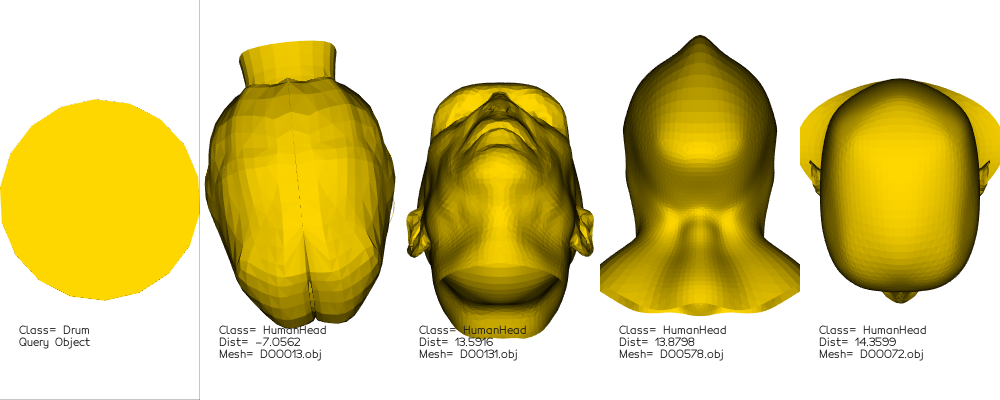

In [17]:
def test_customtopk(x, ret, k=5):
    dist = np.fromiter(
    (ret.dist_func(x, o).sum() for o in ret.X), dtype=x.dtype
    )
    topk_idx = dist.argsort()[:k]
    return topk_idx, dist[topk_idx]

t = 678
dist_plot(t, *test_customtopk(ret.X[t], ret), df_features=df_features).show()

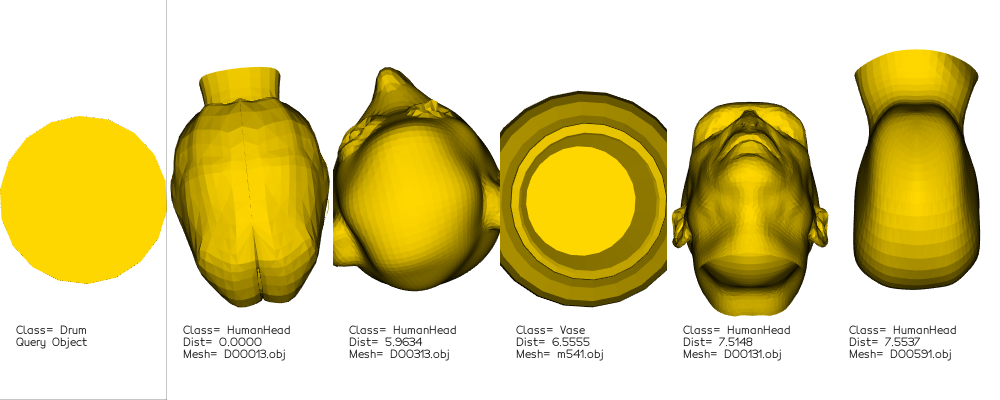

In [ ]:
idx, dist = ret.index.query(ret.X[[t]], k=6)
dist_plot(t, idx.flatten(), dist.flatten(), df_features=df_features).show()

In [ ]:

def test_t(t, ret=ret, df_features=df_features, show=True, k=5):
    dist_plot(t, *test_customtopk(ret.X[t], ret, k=k), df_features=df_features).show()
    idx, dist = ret.index.query(ret.X[[t]], k=k)
    dist_plot(t, idx.flatten(), dist.flatten(), df_features=df_features).show()
    
     
test_t(2000)



custom result


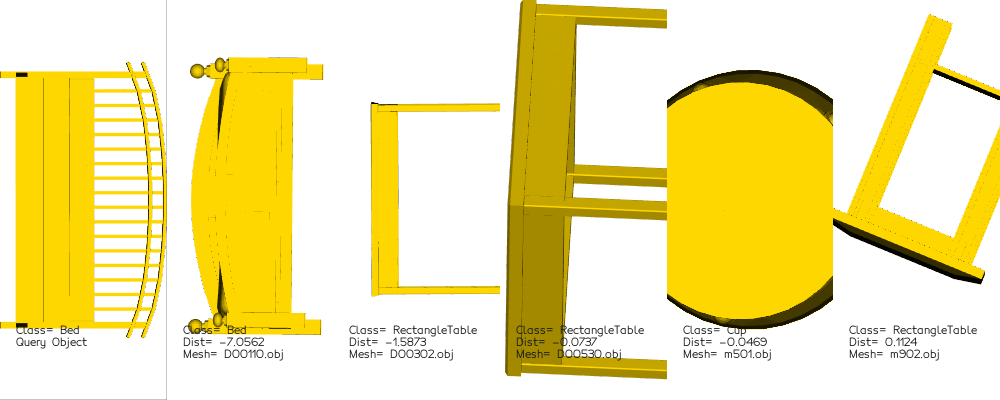

In [30]:
k=6
t=89
print("custom result")
dist_plot(t, *test_customtopk(ret.X[t], ret, k=k), df_features=df_features).show()


In [32]:
print(*test_customtopk(ret.X[t], ret, k=k))

[  89   68 1815 1821  579 1857] [-7.05621147 -1.58732816 -0.07369124 -0.04692916  0.11237024  0.11980386]


ann result


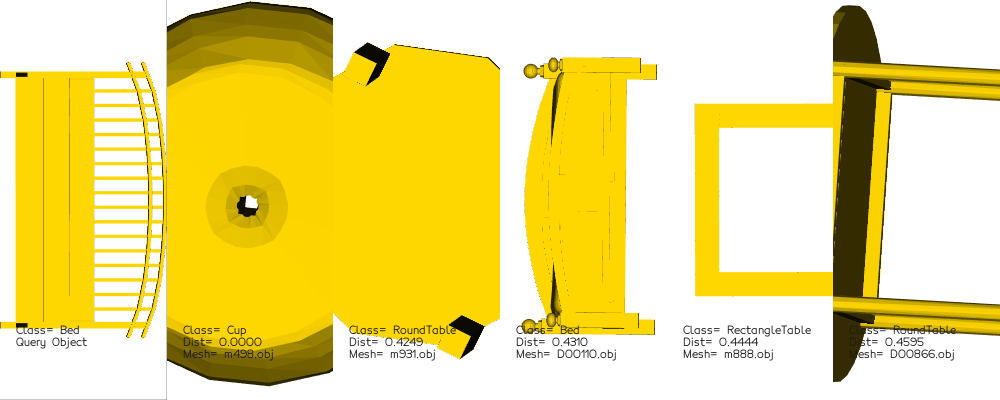

In [31]:
print("ann result")
idx, dist = ret.index.query(ret.X[[t]], k=k)
dist_plot(t, idx.flatten(), dist.flatten(), df_features=df_features).show()

In [ ]:
[test_t(t) for t in [58, 89, 2000]]

Custom distance function
ANN with L2
Custom distance function
ANN with L2
Custom distance function
ANN with L2


[(<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>),
 (<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>),
 (<PIL.Image.Image image mode=RGB size=1000x400>,
  <PIL.Image.Image image mode=RGB size=1000x400>)]

In [ ]:
test_t(1049, k=6)

Custom distance function
ANN with L2


(<PIL.Image.Image image mode=RGB size=1000x400>,
 <PIL.Image.Image image mode=RGB size=1000x400>)

In [ ]:
test_t(1671, k=6)

Custom distance function
ANN with L2


(<PIL.Image.Image image mode=RGB size=1000x400>,
 <PIL.Image.Image image mode=RGB size=1000x400>)

In [ ]:
np.argwhere(df_features['mesh_name'] == 'D00466.obj')

array([[1671]], dtype=int64)

In [ ]:
idx, dist = ret.index.query(ret.X, k=2419)
idx.shape

In [ ]:
idx_sort = idx.argsort()
for i in range(2419):
    idx[i] = idx[i, idx_sort[i]]
    dist[i] = dist[i, idx_sort[i]]

idx[0], dist[0]

(array([   0,    1,    2, ..., 2416, 2417, 2418], dtype=int32),
 array([0.       , 0.4758974, 2.1883402, ..., 4.493675 , 4.414216 ,
        4.7223883], dtype=float32))

In [ ]:
assert np.diag(dist).sum() == 0. # This must be true, otherwise something's wrong

In [ ]:
np.savez_compressed("ann_distances", idx=idx, dist=dist)

In [ ]:
# idx, dist = zip(*(ret(x, k=2419) for x in ret.X[:10]))
from itertools import combinations
from tqdm import tqdm
from math import factorial
total = int(factorial(2419) / (2 * factorial(2419 - 2)))

dist = np.zeros((2419, 2419))

for i, j in tqdm(combinations(range(2419), r=2), total=total):
    idist = ret.dist_func(ret.X[i], ret.X[j]).sum()
    dist[i, j] = idist
    dist[j, i] = idist

dist[np.diag_indices_from(dist)] = [ret.dist_func(ret.X[i], ret.X[i]).sum() for i in range(2419)]
 # Should always be the minimum distance aka -7.056
assert (np.diag(dist) == (-ret.mu / ret.sigma).sum()).all()
np.savez_compressed("custom_distances", dist=dist)


100%|██████████| 2924571/2924571 [10:39<00:00, 4574.53it/s]
